# COGS 118A Group 035 Wi23 - VotingClassifier with all three models
### Group Memebers:
<ul >
  <li style="padding-left: 20px;"> Jamie Wei (A15921963) </li>
  <li style="padding-left: 20px;"> Nicole Rangan (A15011222) </li>
  <li style="padding-left: 20px;"> Sarita Raghunath (A16425750) </li>
  <li style="padding-left: 20px;"> Zehong Li (A15852954) </li>
</ul>


**NOTICE! Running our model requires Tensorflow. The development is constructed with Pip (22.2), Python (3.9.13), and Tensorflow (2.11.0)**

In [1]:
# %pip install SciKeras

In [31]:
# necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

from datetime import datetime

In [3]:
# read csv
df = pd.read_csv('cleaned_data_final.csv')

# a peek at our dataset
df

,match_id,radiant_win,duration,avg_mmr,team1_hero1,team1_hero2,team1_hero3,team1_hero4,team1_hero5,team1_hero6,...,team2_hero119,team2_hero120,team2_hero121,team2_hero123,team2_hero126,team2_hero128,team2_hero129,team2_hero135,team2_hero136,team2_hero137
0,7045889918,False,2199,2607.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7045889915,True,2301,2931.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7045889913,True,2093,1942.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7045889912,False,2856,4332.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,7045889911,False,3539,3942.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91583,6744845900,False,3297,2763.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91584,6744846112,True,1915,2882.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91585,6744847011,False,2101,2159.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
91586,6744847112,True,2494,2107.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# turn labels to 0 and 1s
df['radiant_win'] = df['radiant_win'].replace({True: 1, False: 0})
df

,match_id,radiant_win,duration,avg_mmr,team1_hero1,team1_hero2,team1_hero3,team1_hero4,team1_hero5,team1_hero6,...,team2_hero119,team2_hero120,team2_hero121,team2_hero123,team2_hero126,team2_hero128,team2_hero129,team2_hero135,team2_hero136,team2_hero137
0,7045889918,0,2199,2607.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7045889915,1,2301,2931.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7045889913,1,2093,1942.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7045889912,0,2856,4332.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,7045889911,0,3539,3942.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91583,6744845900,0,3297,2763.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91584,6744846112,1,1915,2882.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91585,6744847011,0,2101,2159.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
91586,6744847112,1,2494,2107.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 4:], df[['radiant_win']], test_size=0.2, random_state=42)

In [6]:
#convert numpy arrays of training to tensors, set to tf.float32
X_train_tensor = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test.values, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

In [7]:
X_train_tensor.shape

TensorShape([73270, 246])

In [8]:
# best parameters from the three models:
nn_best_params = {'activation': 'tanh', 'hidden_layers': 2, 'learning_rate': 0.001, 'nodes': 64, 'regularization_strength': 0.01}
rf_best_params = {'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 7,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'bootstrap': True}
lr_best_params = {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}

In [9]:
# creating neural network
# define a function to create the Keras model
def create_model(learning_rate=0.01, hidden_layers=1, nodes=32, activation='relu', regularization_strength=0.01):
    model = Sequential()
    model.add(Dense(nodes, activation=activation, input_shape=(246,), kernel_regularizer=l2(regularization_strength)))
    model.add(BatchNormalization())
    for i in range(hidden_layers):
        model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(regularization_strength)))
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

nn_clf = KerasClassifier(build_fn=create_model,
                         learning_rate=nn_best_params['learning_rate'],
                         hidden_layers=nn_best_params['hidden_layers'],
                         nodes=nn_best_params['nodes'],
                         activation=nn_best_params['activation'],
                         regularization_strength=nn_best_params['regularization_strength'],
                         epochs=100,
                         batch_size=32,
                         verbose=0)

In [10]:
# creating random forest
rf_clf = RandomForestClassifier(**rf_best_params, random_state = 42, verbose = 3)

In [11]:
# creating logistic regression
lr_clf = LogisticRegression(**lr_best_params, random_state = 42, verbose = 3)

In [22]:
voting_clf = VotingClassifier(
    estimators=[('nn', nn_clf), ('rf', rf_clf), ('logit', lr_clf)],
    voting='hard', verbose = True)

In [24]:
voting_clf.fit(X_train, y_train.values.ravel())

C:\Users\Dominic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


[Voting] ....................... (1 of 3) Processing nn, total= 4.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   34.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 70 epochs took 19 seconds
[Voting] .................... (3 of 3) Processing logit, total=  18.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s finished


VotingClassifier(estimators=[('nn',
                              KerasClassifier(activation='tanh', batch_size=32, build_fn=<function create_model at 0x000001D06C1CB940>, epochs=100, hidden_layers=2, learning_rate=0.001, nodes=64, regularization_strength=0.01, verbose=0)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=7,
                                                     min_samples_split=5,
                                                     n_estimators=1000,
                                                     random_state=42,
                                                     verbose=3)),
                             ('logit',
                              LogisticRegression(C=10, l1_ratio=0.5,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 verbose=3))],
                 verbose=True)

In [40]:
yhat_te = voting_clf.predict(X_test)

yhat_tr = voting_clf.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


In [41]:
# define a show metric function
def show_metrics(y_tr, y_te, yhat_tr, yhat_te, named):
    # accuracy scores for training and test sets
    acc_train = accuracy_score(y_tr, yhat_tr)
    acc_test = accuracy_score(y_te, yhat_te)

    print(f'training set accuracy (n={y_tr.shape[0]}): {acc_train:4.5f}')
    print(f'test set accuracy (n={y_te.shape[0]}): {acc_test:4.5f}')
    print()
    print('classificiation report on test set performance')
    print(classification_report(y_te, yhat_te, digits = 5))
    print()

    with sns.axes_style('white'):
        # confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_te, yhat_te)
        plt.show()
        
        # roc-auc
        fpr, tpr, thresholds = roc_curve(y_te, yhat_te) 
        roc_auc = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name=named)
        roc_display.plot()
        plt.title('ROC Curve')
        plt.show()
        
        # precision-recall auc
        precision, recall, thresholds = precision_recall_curve(y_te, yhat_te)
        pr_auc = auc(recall, precision)
        pr_display = PrecisionRecallDisplay(precision=precision, recall=recall,
                                             average_precision=pr_auc,
                                             estimator_name=named)
        pr_display.plot()
        plt.title('Precision-Recall Curve')
        plt.show()
        
        # balanced accuracy
        tn, fp, fn, tp = confusion_matrix(y_te, yhat_te).ravel()
        balanced_accuracy = (tp/(tp+fn) + tn/(tn+fp))/2
        print(f'Balanced accuracy: {balanced_accuracy:.5f}')
        
        # specificity and negative predictive value
        specificity = tn / (tn + fp)
        npv = tn / (tn + fn)
        print(f'Specificity: {specificity:.5f}')
        print(f'Negative predictive value: {npv:.5f}')
        
        # false positive and false negative rates
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        print(f'False positive rate: {fpr:.5f}')
        print(f'False negative rate: {fnr:.5f}')

training set accuracy (n=73270): 0.57240
test set accuracy (n=18318): 0.55552

classificiation report on test set performance
              precision    recall  f1-score   support

           0    0.55610   0.50320   0.52833      9062
           1    0.55505   0.60674   0.57975      9256

    accuracy                        0.55552     18318
   macro avg    0.55557   0.55497   0.55404     18318
weighted avg    0.55557   0.55552   0.55431     18318




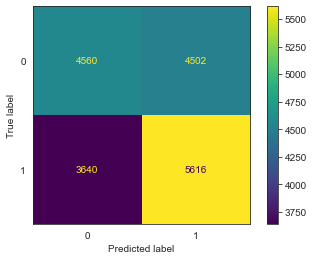

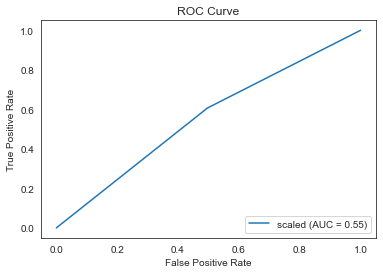

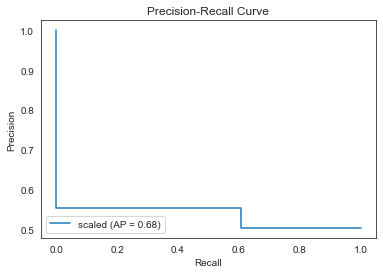

Balanced accuracy: 0.55497
Specificity: 0.50320
Negative predictive value: 0.55610
False positive rate: 0.49680
False negative rate: 0.39326


In [34]:
#show our metrics
show_metrics(y_train, y_test, yhat_tr, yhat_te, 'scaled')